In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import torch

class TriangularWaveFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, t):
        # Save context for backward computation
        ctx.save_for_backward(t)
        return 2 * torch.abs(2 * ( t - torch.floor((t + 0.5))) ) - 1

    @staticmethod
    def backward(ctx, grad_output):
        t, = ctx.saved_tensors
        # Compute the gradient using the square_wave function
        grad_input = grad_output * (-2 * (torch.floor(2*t ) % 2) + 1)
        return grad_input

def triangular_wave(t):
    return TriangularWaveFunction.apply(t)

torch.triangular_wave = triangular_wave


##next i want to add phi with the triangle wave and see if that works. just do phi and amplitude?!
#init? should the amplitudes be increasing or anything like that? what happens when your amplitude descreases? is that interesting?


class CustomSinLayer(nn.Module):
    def __init__(self,e=0.001):
        super(CustomSinLayer, self).__init__()
        # Initialize the parameters
        
        self.add_param = nn.Parameter(torch.randn(1))  # Parameter to be added
        #self.mul_param = nn.Parameter(torch.randn(1))  # Parameter to be multiplied
        self.amplitude = nn.Parameter(torch.randn(1))
        self.e = e
    def forward(self, x):
        # Apply the parameters to the input and then the sin function
        #f = self.mul_param  #**2 + self.e
        out = self.amplitude * torch.sin( x + self.add_param)
        return out
    
    def set_layer_params(self, amp_value,  mul_value, add_value):

        with torch.no_grad():  # Disable gradient tracking
            self.amplitude.copy_(torch.tensor([amp_value]))
            self.add_param.copy_(torch.tensor([add_value]))
            #self.mul_param.copy_(torch.tensor([mul_value]))

class CustomSinNetwork(nn.Module):
    def __init__(self, L, e=0.001):
        super(CustomSinNetwork, self).__init__()
        # Create L instances of CustomSinLayer
        self.layers = nn.ModuleList([CustomSinLayer(e) for _ in range(L)])
    
    def forward(self, x):
        # Pass the input through each layer sequentially
        for layer in self.layers:
            x = layer(x)
        return x

class SinAndLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SinAndLinearLayer, self).__init__()
        # Initialize the parameters
        self.coeff = nn.Parameter(torch.randn(input_dim,output_dim))
        
        
    def forward(self, x):
        # Apply the parameters to the input and then the sin function
        #f = self.mul_param  #**2 + self.e
        #print(x.shape)
        out = torch.matmul(torch.sin(x),self.coeff)
        return out
    
class SinAndLinearLayer2(nn.Module):
    def __init__(self, input_dim, output_dim):
        """This has a phi afterward"""
        super(SinAndLinearLayer2, self).__init__()
        # Initialize the parameters
        self.coeff = nn.Parameter(torch.randn(input_dim,output_dim))
        self.phi = nn.Parameter(torch.randn(output_dim))
        
    def forward(self, x):
        # Apply the parameters to the input and then the sin function
        #f = self.mul_param  #**2 + self.e
        #print(x.shape)
        out = torch.matmul(torch.sin(x),self.coeff) + self.phi
        return out   
    
class SinAndLinearLayer3(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SinAndLinearLayer3, self).__init__()
        """
        has a phi before.
        """
        # Initialize the parameters
        self.coeff = nn.Parameter(torch.randn(input_dim,output_dim))
        self.phi = nn.Parameter(torch.randn(input_dim))
        
    def forward(self, x):
        # Apply the parameters to the input and then the sin function
        #f = self.mul_param  #**2 + self.e
        #print(x.shape)
        out = torch.matmul((torch.sin(x) + self.phi),self.coeff) 
        return out  
    
class SinWaveLayer(nn.Module):
    def __init__(self):
        super(SinWaveLayer, self).__init__()
        """
        Sin wave with amplitude and phi params. 
        
        """
        
        self.phi = nn.Parameter(torch.randn(1)) 
        self.amplitude = nn.Parameter(torch.randn(1))
        
    def forward(self, t):
        out = self.amplitude * torch.sin( t + self.phi)
        return out
class TriangleWaveLayer(nn.Module):
    def __init__(self):
        super(TriangleWaveLayer, self).__init__()
        """
        Triangle wave.  a and phi only.  and only 1 per layer
        """
        self.phi = nn.Parameter(torch.randn(1))  # Parameter to be added
        self.amplitude = nn.Parameter(torch.randn(1))

    def forward(self, t):
        out = self.amplitude * torch.triangular_wave( t + self.phi)
        return out
class TriangleChainNetwork(nn.Module):
    def __init__(self, L):
        super(TriangleChainNetwork, self).__init__()
        """Triangle waves with a sin wave at the end.  L is just number of layers"""
        self.layers = nn.ModuleList([TriangleWaveLayer() for _ in range(L-1)])
        self.sin_layer = SinWaveLayer()
    def forward(self, x):

        for layer in self.layers:
            x = layer(x)
        x = self.sin_layer(x)
        return x

class TriangleCombinationLayer(nn.Module):
    def __init__(self, param_dim):
        super(TriangleCombinationLayer, self).__init__()
        """
        Triangle wave.  a and phi only.  and only 1 per layer
        """
        self.phi = nn.Parameter(torch.randn(param_dim))  # Parameter to be added
        self.amplitude = nn.Parameter(torch.randn(param_dim))

    def forward(self, t):
        out = self.amplitude * torch.triangular_wave( t + self.phi)
        out = out.sum(dim = -1).unsqueeze(1)
        return out  
    
    
class TriangleLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TriangleLinearLayer, self).__init__()
        """
        Triangle wave.  a and phi only.  and only 1 per layer
        """
        self.phi = nn.Parameter(torch.randn(input_dim))  # Parameter to be added
        self.amplitude = nn.Parameter(torch.randn(input_dim, output_dim)) # what shape is this...

    def forward(self, t):
        
        out = torch.matmul(torch.triangular_wave(t + self.phi),self.amplitude)
        return out 
    
class TriangleLinearNetwork(nn.Module):
    def __init__(self,layer_dims):
        super(TriangleLinearNetwork, self).__init__()
        self.layers = nn.ModuleList([TriangleLinearLayer(i[0],i[1]) for i in layer_dims[:-1] ])
        self.final = SinAndLinearLayer3(layer_dims[-1][0],layer_dims[-1][1])
        #self.out = SinWaveLayer()
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

    
class TriangleCombinationSinFinalNetwork(nn.Module):
    def __init__(self,layer_dims):
        super(TriangleCombinationSinFinalNetwork, self).__init__()
        self.layers = nn.ModuleList([TriangleCombinationLayer(i) for i in layer_dims ])
        self.out = SinWaveLayer()
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.out(x)
        return x

def plot_layer_output(t, output,connect=True):
    """
    Plots the output of the custom layer.
    
    Args:
    - t (torch.Tensor): The x-axis values (input tensor).
    - output (torch.Tensor): The y-axis values (output tensor from the custom layer).
    """
    # Convert tensors to numpy arrays for plotting
    t = t.detach().numpy()
    output = output.detach().numpy()
    
    # Create the plot
    plt.figure(figsize=(20, 6))
    if connect:
        plt.plot(t, output, label='Layer Output')
    else:
        plt.scatter(t, output, label='Layer Output')
    plt.xlabel('t')
    plt.ylabel('Output')
    plt.title('Custom Layer Output vs t')
    plt.legend()
    plt.grid(True)
    plt.show()



In [2]:
plot_layer_output(t, output,connect=True)

NameError: name 't' is not defined

In [130]:
class testN(nn.Module):
    def __init__(self,layer_dims):
        super(testN, self).__init__()
        self.layers = nn.ModuleList([SinAndLinearLayer2(i[0],i[1]) for i in layer_dims ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
network_config = [[1,10],[10,20],[20,1]]
n = TriangleLinearNetwork(network_config)
t = torch.from_numpy(np.arange(500)).unsqueeze(1)
n

TriangleLinearNetwork(
  (layers): ModuleList(
    (0): TriangleLinearLayer()
    (1): TriangleLinearLayer()
  )
  (final): SinAndLinearLayer3()
)

In [5]:
# Example usage:
L = 5  # Number of layers
model = CustomSinNetwork(L)

# Forward pass
x = torch.from_numpy(np.arange(100))
output = model(x)
output

tensor([ 0.0190, -0.0070,  0.0506,  0.0103,  0.1105, -0.0366,  0.0180,  0.0099,
        -0.0327,  0.0407,  0.0597, -0.0438,  0.0134,  0.0169, -0.0436,  0.0962,
         0.0178,  0.0126,  0.0005,  0.0189, -0.0203,  0.0984,  0.0060,  0.1041,
        -0.0230,  0.0188,  0.0023,  0.0031,  0.0206,  0.0908, -0.0448,  0.0165,
         0.0141, -0.0451,  0.0656,  0.0361, -0.0278,  0.0087,  0.0182, -0.0342,
         0.1122,  0.0089,  0.0612, -0.0093,  0.0190, -0.0084,  0.0572,  0.0094,
         0.1117, -0.0352,  0.0181,  0.0091, -0.0298,  0.0378,  0.0633, -0.0447,
         0.0138,  0.0167, -0.0444,  0.0929,  0.0195,  0.0066,  0.0017,  0.0188,
        -0.0219,  0.1021,  0.0060,  0.1008, -0.0213,  0.0188,  0.0012,  0.0089,
         0.0189,  0.0942, -0.0441,  0.0168,  0.0137, -0.0444,  0.0619,  0.0389,
        -0.0309,  0.0094,  0.0181, -0.0357,  0.1113,  0.0098,  0.0547, -0.0079,
         0.0190, -0.0099,  0.0636,  0.0086,  0.1124, -0.0337,  0.0183,  0.0084,
        -0.0265,  0.0351,  0.0669, -0.04

In [6]:
test = TriangleCombinationLayer(10)
test2 = TriangleCombinationLayer(20)
x = torch.from_numpy(np.arange(10)).unsqueeze(1).float()
i1 = test(x)
print(i1.shape)
i2 = test2(i1)
print(i2.shape)

torch.Size([10, 1])
torch.Size([10, 1])


In [7]:
dims = [5,5,5]
testn = TriangleCombinationSinFinalNetwork(dims)
testn

TriangleCombinationSinFinalNetwork(
  (layers): ModuleList(
    (0): TriangleCombinationLayer()
    (1): TriangleCombinationLayer()
    (2): TriangleCombinationLayer()
  )
  (out): SinWaveLayer()
)

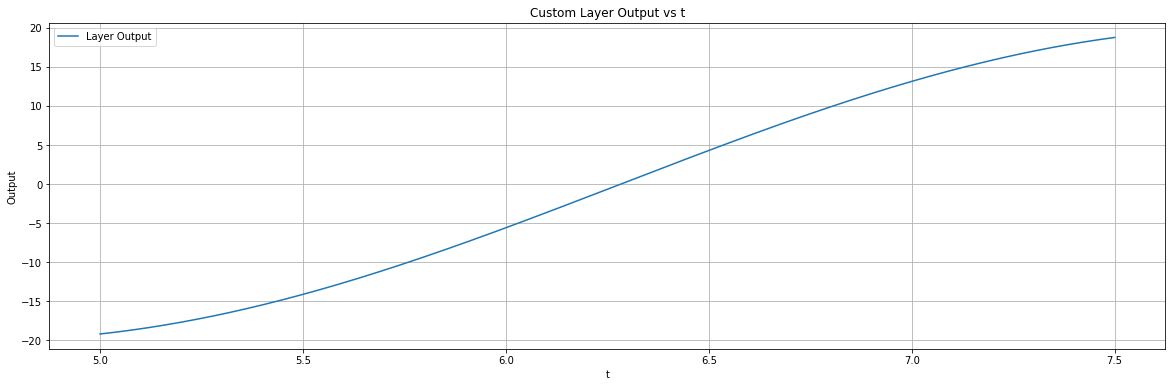

In [8]:
t = torch.from_numpy(np.linspace(5,7.5,500))
layer = CustomSinLayer()
layer.set_layer_params(20,0.01,0.0)
output = layer(t)
plot_layer_output(t, output)

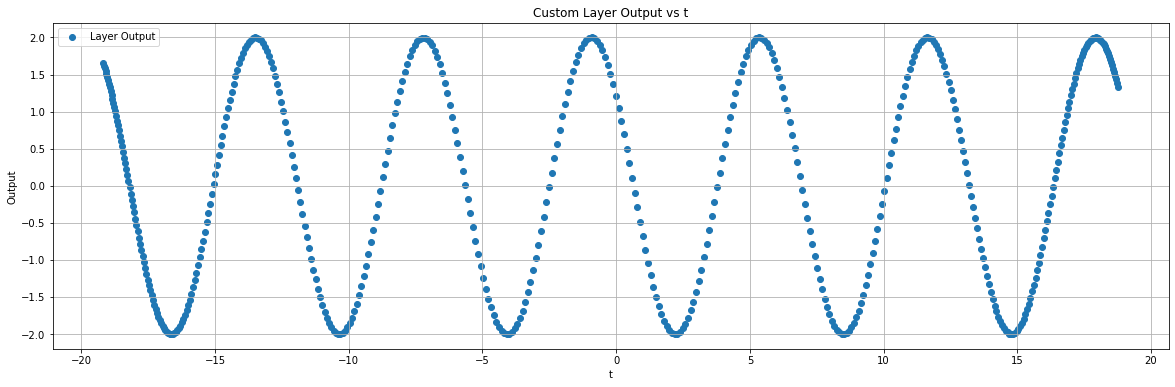

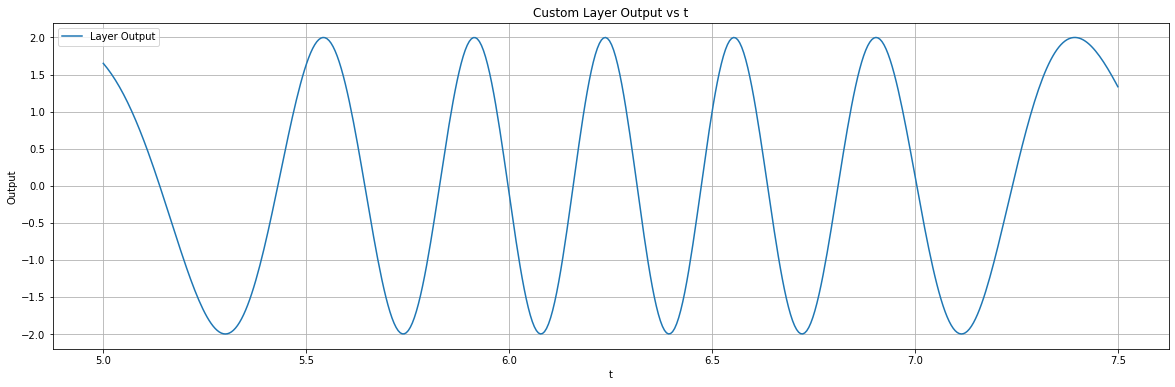

In [9]:
layer2 = CustomSinLayer()
layer2.set_layer_params(2,0.01,2.5)
out2 = layer2(output)

plot_layer_output(output,out2, False)
plot_layer_output(t, out2)

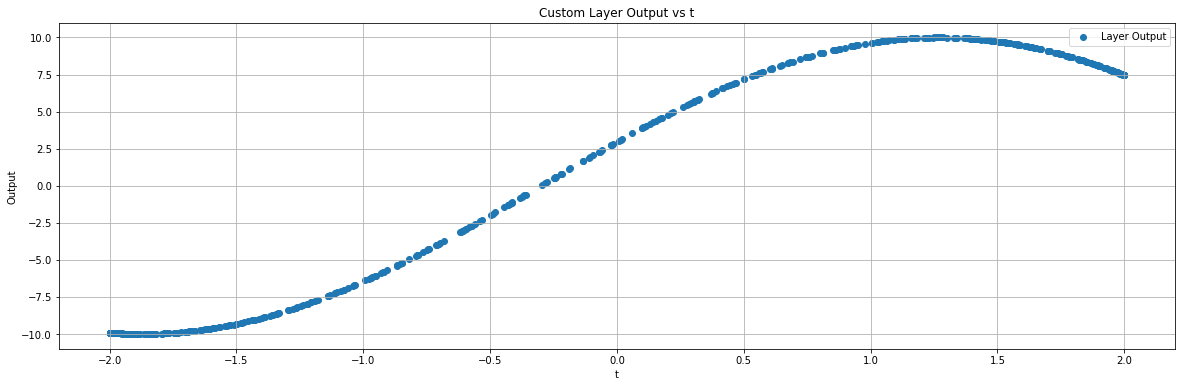

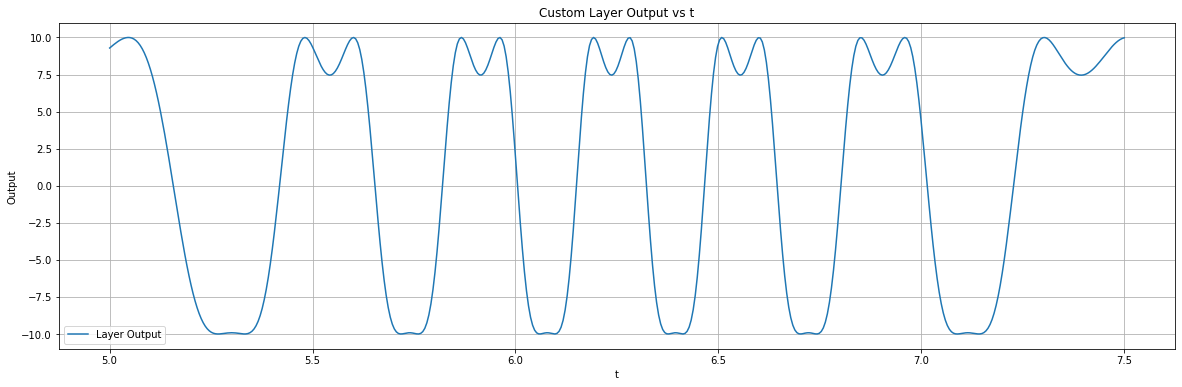

In [10]:
layer3 = CustomSinLayer()
layer3.set_layer_params(10,0.01,0.3)
out3 = layer3(out2)
plot_layer_output(out2,out3, False)
plot_layer_output(t, out3)


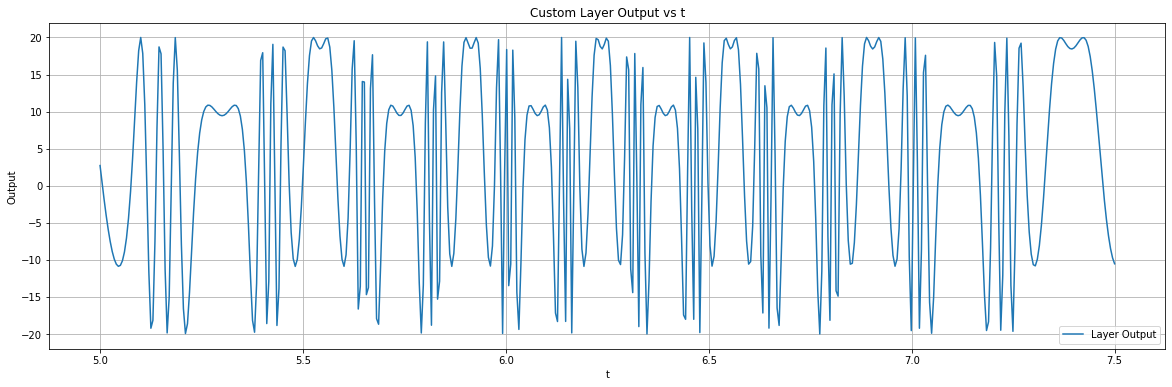

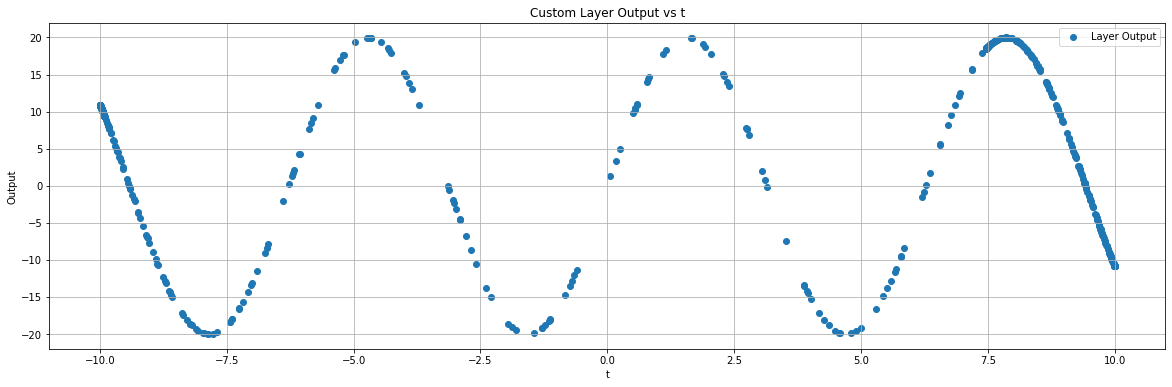

In [11]:
layer4 = CustomSinLayer()
layer4.set_layer_params(20,0.01,0.0)
out4 = layer4(out3)
plot_layer_output(t, out4)
plot_layer_output(out3,out4, False)

In [4]:
t, out2, output

NameError: name 't' is not defined

In [5]:
t_big = t.unsqueeze(1) - t.unsqueeze(1).T
o_big = output.unsqueeze(1) - output.unsqueeze(1).T
o2_big = out2.unsqueeze(1) - out2.unsqueeze(1).T

NameError: name 't' is not defined

In [6]:
torch.mean(t_big * (o_big - o2_big))

NameError: name 't_big' is not defined

In [7]:
vals = [(i/100) + 1.5 for i in range(300)]
res = []
for i in vals:
    layer.set_layer_params(1,i,0.1)
    output = layer(t)
    cos_sim =  F.cosine_similarity(output, out2, dim=0)
    res.append(cos_sim)

NameError: name 'layer' is not defined

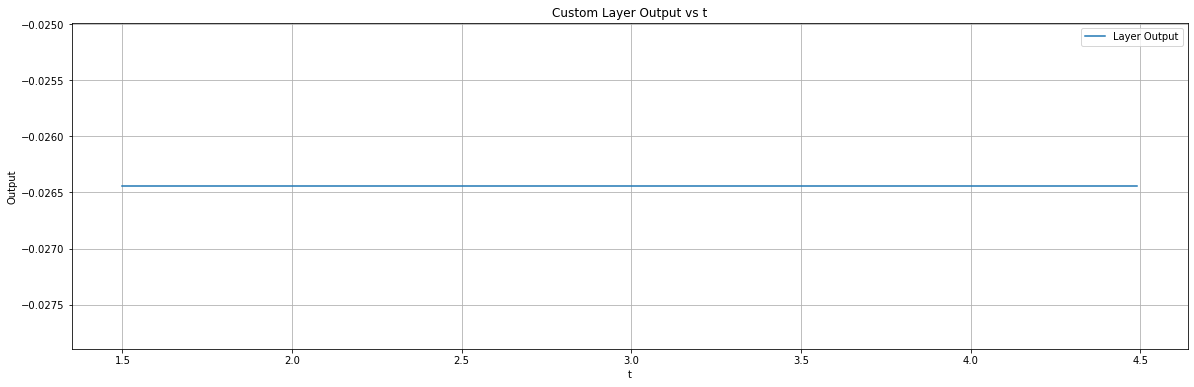

In [490]:
plot_layer_output(torch.tensor(vals),torch.tensor(res))

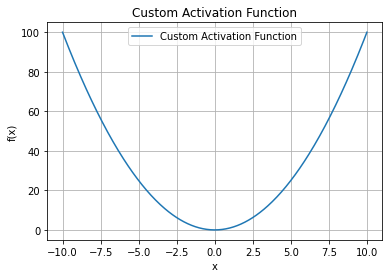

In [8]:
import numpy as np
import matplotlib.pyplot as plt
### put this in front of the sin function for the t coefficient, only positive frequencies, never exactly 0 because
### of e, same for amplitude i think.  the phase should stay in a range, but i may let that just be free, since there
### are infinite correct 
def square_activation(x,e):
    return (x**2) + e

# Generating values for x
x = np.linspace(-10, 10, 400)
# Applying the custom activation function
y = square_activation(x,e=0.001)

# Plotting the function
plt.plot(x, y, label="Custom Activation Function")
plt.title("Custom Activation Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
y

array([1.00001000e+02, 9.90010063e+01, 9.80060377e+01, 9.70160941e+01,
       9.60311757e+01, 9.50512823e+01, 9.40764141e+01, 9.31065709e+01,
       9.21417529e+01, 9.11819599e+01, 9.02271920e+01, 8.92774493e+01,
       8.83327316e+01, 8.73930390e+01, 8.64583715e+01, 8.55287291e+01,
       8.46041118e+01, 8.36845196e+01, 8.27699525e+01, 8.18604104e+01,
       8.09558935e+01, 8.00564017e+01, 7.91619349e+01, 7.82724933e+01,
       7.73880767e+01, 7.65086853e+01, 7.56343189e+01, 7.47649776e+01,
       7.39006614e+01, 7.30413703e+01, 7.21871044e+01, 7.13378635e+01,
       7.04936477e+01, 6.96544570e+01, 6.88202913e+01, 6.79911508e+01,
       6.71670354e+01, 6.63479451e+01, 6.55338798e+01, 6.47248397e+01,
       6.39208246e+01, 6.31218347e+01, 6.23278698e+01, 6.15389300e+01,
       6.07550154e+01, 5.99761258e+01, 5.92022613e+01, 5.84334219e+01,
       5.76696076e+01, 5.69108184e+01, 5.61570543e+01, 5.54083153e+01,
       5.46646014e+01, 5.39259125e+01, 5.31922488e+01, 5.24636102e+01,
      

In [12]:

from torch.utils.data import Dataset, DataLoader, Sampler
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = torch.randperm(len(self.data_source)).tolist()
        for i in range(0, len(indices), self.batch_size):
            yield indices[i:i + self.batch_size]

    def __len__(self):
        return len(self.data_source) // self.batch_size

class WaveformDatasetConsecutive(Dataset):
    def __init__(self, wav_data,t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSamplerConsecutive(Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_batches = len(self.data_source) // self.batch_size

    def __iter__(self):
        # Create a list of starting indices for each batch
        starting_indices = list(range(0, len(self.data_source) - self.batch_size + 1, self.batch_size))
        # Shuffle the starting indices
        np.random.shuffle(starting_indices)
        # Yield batches of consecutive indices
        for start_idx in starting_indices:
            yield list(range(start_idx, start_idx + self.batch_size))

    def __len__(self):
        return self.num_batches

# Example usage

class PhaseAgreementLoss(nn.Module):
    def __init__(self):
        super(PhaseAgreementLoss, self).__init__()
    
    def forward(self, input, target):
        product = input * target
        loss = torch.sum(1- torch.sigmoid(product +2))
        return loss
   
class ProximalDiffLoss(nn.Module):
    def __init__(self):
        super(ProximalDiffLoss, self).__init__()
    
    def forward(self, input, target):
        
        in_dif = input -input.T
        t_dif = target - target.T
        dif = in_dif - t_dif
        square = dif **2
        return torch.mean(square)
    
class SquareAreaLoss(nn.Module):
    def __init__(self):
        super(SquareAreaLoss, self).__init__()
    
    def forward(self, t, input, target):
        
        t_dif = t - t.T #no negative distances.
        in_dif = input -input.T
        t_dif = target - target.T
        dif = in_dif - t_dif
        areas = dif * t_dif
        sqa = areas **2
        return torch.mean(sqa)

class InverseAreaLoss(nn.Module):
    def __init__(self):
        super(InverseAreaLoss, self).__init__()
    
    def forward(self, t, input, target):
        
        t_dif = 0.01/(t - t.T) #no negative distances.
        in_dif = input -input.T
        t_dif = target - target.T
        dif = in_dif - t_dif
        areas = dif * t_dif
        sqa = areas **2
        return torch.mean(sqa)
    
class ProximalCDLoss(nn.Module):
    def __init__(self):
        super(ProximalCDLoss, self).__init__()
    
    def forward(self, input, target):
        
        in_dif = input -input.T
        t_dif = target - target.T
        cd = 1 - F.cosine_similarity(in_dif, t_dif)
        #square = cd **2
        return torch.mean(cd)

class BatchAreaDiffLoss(nn.Module):
    def __init__(self):
        super(BatchAreaDiffLoss, self).__init__()
    
    def forward(self, t, pred,target):
        t = t - t.T
        
        pred = pred - pred.T
        
        target = target - target.T
        loss = torch.abs(t * (target - pred))
        loss = torch.mean(loss)
        
        return loss
                         
class BatchAreaCDLoss(nn.Module):
    def __init__(self):
        super(BatchAreaCDLoss, self).__init__()
    
    def forward(self, t, pred,target):
        t = t - t.T
        
        pred = pred - pred.T
        
        target = target - target.T
        pred = t*pred
        pred = pred.flatten()
        target = t*target
        target = target.flatten()
        loss = 1 - F.cosine_similarity(pred, target, dim=0)
        
        return loss

In [122]:
# Define a loss function and optimizer
hyperparameters = {'learning_rate': 0.01
                   , 'epochs': 1000
                   ,'batch_size': 400}

In [91]:
L = 3  # Number of layers
data_t = torch.from_numpy(np.linspace(1,10,1000))
data_gen_network = CustomSinNetwork(L)
data_gen_network.eval()
data =  16*torch.sin(2*data_t+3)  #+ 3*torch.sin(6*data_t+1.93) 
data = data.detach().numpy().astype(np.float64)


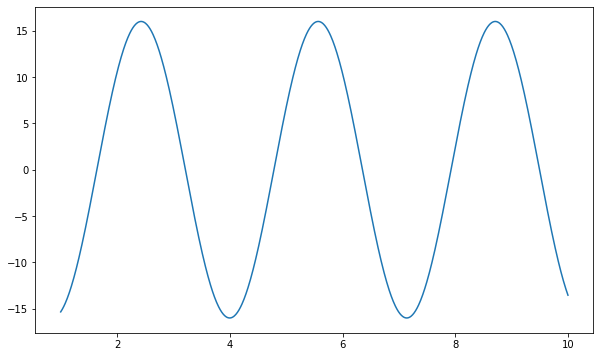

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(data_t, data, label='Layer Output')
#plt.scatter(t, output, label='Layer Output')

In [43]:
L = 5  # Number of layers
network = CustomSinNetwork(L)
network.train()

CustomSinNetwork(
  (layers): ModuleList(
    (0): CustomSinLayer()
    (1): CustomSinLayer()
    (2): CustomSinLayer()
    (3): CustomSinLayer()
    (4): CustomSinLayer()
  )
)

In [131]:
network_config = [[1,10],[10,20],[20,50],[50,20],[20,10],[10,1]]
network = testN(network_config)
network.train()

testN(
  (layers): ModuleList(
    (0): SinAndLinearLayer2()
    (1): SinAndLinearLayer2()
    (2): SinAndLinearLayer2()
    (3): SinAndLinearLayer2()
    (4): SinAndLinearLayer2()
    (5): SinAndLinearLayer2()
  )
)

In [8]:
L = 5  # Number of layers
network = TriangleChainNetwork(L)
network.train()

TriangleChainNetwork(
  (layers): ModuleList(
    (0): TriangleWaveLayer()
    (1): TriangleWaveLayer()
    (2): TriangleWaveLayer()
    (3): TriangleWaveLayer()
  )
  (sin_layer): SinWaveLayer()
)

In [104]:
dims = [5,5,5]
network = TriangleCombinationSinFinalNetwork(dims)
network.train()

TriangleCombinationSinFinalNetwork(
  (layers): ModuleList(
    (0): TriangleCombinationLayer()
    (1): TriangleCombinationLayer()
    (2): TriangleCombinationLayer()
  )
  (out): SinWaveLayer()
)

In [38]:
network_config = [[1,100],[100,100],[100,1]]
network = TriangleLinearNetwork(network_config)
#t = torch.from_numpy(np.arange(500)).unsqueeze(1)
BUG HERE!!!!

SyntaxError: invalid syntax (4017543774.py, line 4)

In [110]:
# Create the dataloader with the custom random batch sampler
dataset = WaveformDataset(data,data_t)
batch_size = hyperparameters['batch_size']
sampler = RandomBatchSampler(dataset, batch_size)
dataloader = DataLoader(dataset, batch_sampler=sampler)


In [132]:
#consecutive t dataset, useful for proximal loss stuff
dataset = WaveformDatasetConsecutive(data,data_t)
batch_size = hyperparameters['batch_size']
sampler = RandomBatchSamplerConsecutive(dataset, batch_size)
dataloader = DataLoader(dataset, batch_sampler=sampler)  

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the loss function and optimizer
loss_function =  PhaseAgreementLoss() 
mse_loss = nn.MSELoss() 
pcd_loss = ProximalCDLoss() #ProximalDiffLoss()
pd_loss = ProximalDiffLoss()
optimizer = optim.Adam(network.parameters(), lr=hyperparameters['learning_rate'])
bad_loss =  BatchAreaDiffLoss() #BatchAreaCDLoss()
sqa_loss = SquareAreaLoss()
ia_loss = InverseAreaLoss()

######gradients to store:
store_grad = False
if store_grad:
    gradients = {}


# Training loop
for epoch in range(hyperparameters['epochs']):
#for epoch in range(20_000):
    network.train()  # Set the network to training mode
    epoch_loss = 0.0

    for batch in dataloader:
        targets, inputs = batch
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = network(inputs)
        inputs = inputs.unsqueeze(1).float()
        input_activation = torch.ones_like(inputs).float()
        outputs = network(inputs)

        # Compute the loss
        loss = loss_function(outputs, targets.unsqueeze(1).float())
        mse = mse_loss(outputs, targets.unsqueeze(1).float())
        b_loss = bad_loss(inputs, outputs, targets.unsqueeze(1).float())
        pd = pd_loss(outputs, targets.unsqueeze(1).float())
        pcd = pcd_loss(outputs, targets.unsqueeze(1).float())
        sqa = sqa_loss(inputs, outputs, targets.unsqueeze(1).float())
        ia = ia_loss(inputs, outputs, targets.unsqueeze(1).float())
        loss =  pd + mse ##up mse.  hyper param, or maybe this moves? idk.  i bet this will be a bitch to train.
        #loss = mse
        #print(loss.dtype,outputs.dtype, targets.dtype)
        # Backward pass and optimize
        loss.backward()
        
        optimizer.step()
        
        #store gradients if you wanna
        if store_grad:
            for layer_name, layer in network.layers.named_children():
                if layer_name not in gradients:
                    gradients[layer_name] = {'a1': [], 'a2': [], 'c1': [], 'c2': []}

                gradients[layer_name]['a1'].append(layer.a1.detach().cpu().numpy().flatten())
                gradients[layer_name]['a2'].append(layer.a2.detach().cpu().numpy().flatten())
                gradients[layer_name]['c1'].append(layer.c1.detach().cpu().numpy().flatten())
                gradients[layer_name]['c2'].append(layer.c2.detach().cpu().numpy().flatten())

        epoch_loss += loss.item()

        #print(network.layers[0].c1.grad, network.layers[3].c1.grad)
        # Accumulate the loss for this batch
        epoch_loss += loss.item()

    # Calculate and print the average loss for this epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    if epoch% 100 ==0:
        print(f'Epoch [{epoch}/{hyperparameters["epochs"]}], Loss: {avg_epoch_loss:.4f}')

print("Training completed.")


Epoch [0/1000], Loss: 757.7486
Epoch [100/1000], Loss: 711.8303
Epoch [200/1000], Loss: 722.3604
Epoch [300/1000], Loss: 723.3593
Epoch [400/1000], Loss: 723.8640
Epoch [500/1000], Loss: 723.3128
Epoch [600/1000], Loss: 715.5030
Epoch [700/1000], Loss: 716.4515
Epoch [800/1000], Loss: 703.7816
Epoch [900/1000], Loss: 706.8137
Training completed.


/var/folders/hq/zz_5zb251633yqqbh6076p782zzx8q/T/ipykernel_35779/2037842079.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_list, dtype=torch.float32)


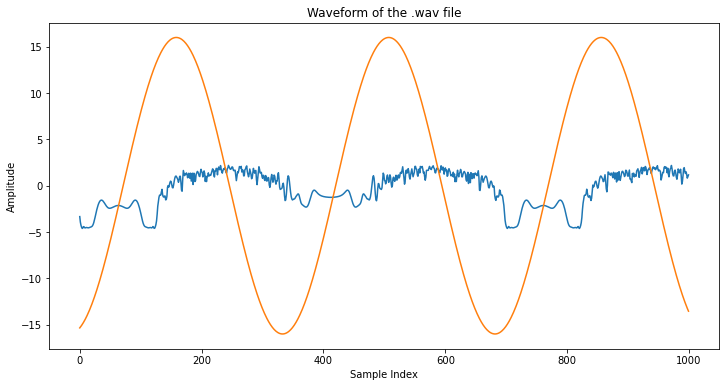

In [134]:
#t = data_t
network.eval()

def run_inference_in_batches(network, input_list, batch_size=100):
    # Convert the input list to a PyTorch tensor
    input_tensor = torch.tensor(input_list, dtype=torch.float32)
    
    # List to collect the outputs
    outputs = []
    
    # Process the input tensor in batches
    for start in range(0, len(input_tensor), batch_size):
        end = min(start + batch_size, len(input_tensor))
        batch = input_tensor[start:end]
        
        # Pass the batch through the network
        with torch.no_grad():  # No need to compute gradients during inference
            batch_output = network(batch.unsqueeze(1))
        
        # Append the batch output to the outputs list
        outputs.append(batch_output)
    
    # Concatenate all batch outputs into a single tensor
    final_output = torch.cat(outputs, dim=0)
    
    return final_output

o = run_inference_in_batches(network, data_t)
#o = torch.sum(o,dim = -1)
plt.figure(figsize=(12, 6))
plt.plot(o)
plt.plot(data)
plt.title('Waveform of the .wav file')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

In [249]:
o.shape

torch.Size([1000])